c:\Users\AlbinXavier\personal\gowtham\nz-tourism\.venv\Lib\site-packages\statsmodels\tsa\filters\hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)
c:\Users\AlbinXavier\personal\gowtham\nz-tourism\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\AlbinXavier\personal\gowtham\nz-tourism\.venv\Lib\site-packages\statsmodels\tsa\filters\hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)


[UCM] Hold-out accuracy (2024-07-31 00:00:00 → 2025-06-30 00:00:00):
   RMSE   : 174.009
   MAE    : 139.046
   MAPE%  : 3.568
   sMAPE% : 3.669
[UCM] UCM – International Annual Spend (no exog) | AIC (full-history): -70.36


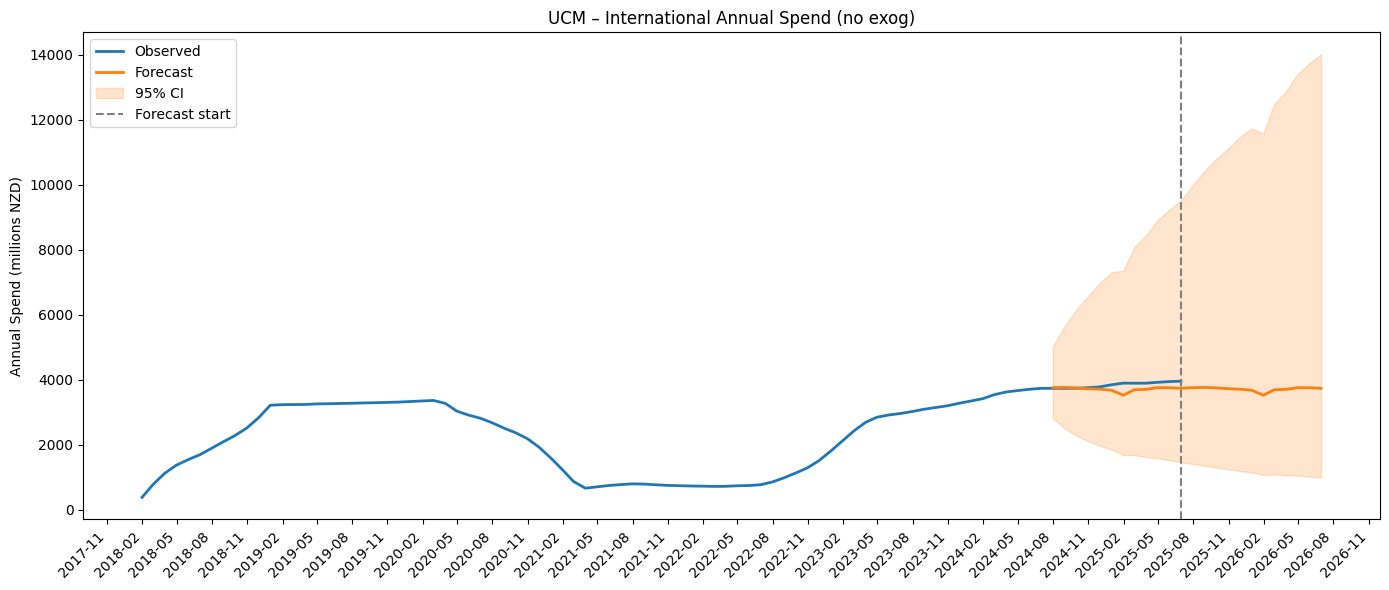


Forecast results written to: ../output/Model_01_UCM_TECT_AnnualSpend_international.csv (International)
[UCM] Hold-out accuracy (2024-07-31 00:00:00 → 2025-06-30 00:00:00):
   RMSE   : 373.422
   MAE    : 309.085
   MAPE%  : 2.767
   sMAPE% : 2.784
[UCM] UCM – Domestic Annual Spend (no exog) | AIC (full-history): -114.92


c:\Users\AlbinXavier\personal\gowtham\nz-tourism\.venv\Lib\site-packages\statsmodels\tsa\filters\hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)
c:\Users\AlbinXavier\personal\gowtham\nz-tourism\.venv\Lib\site-packages\statsmodels\tsa\filters\hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)


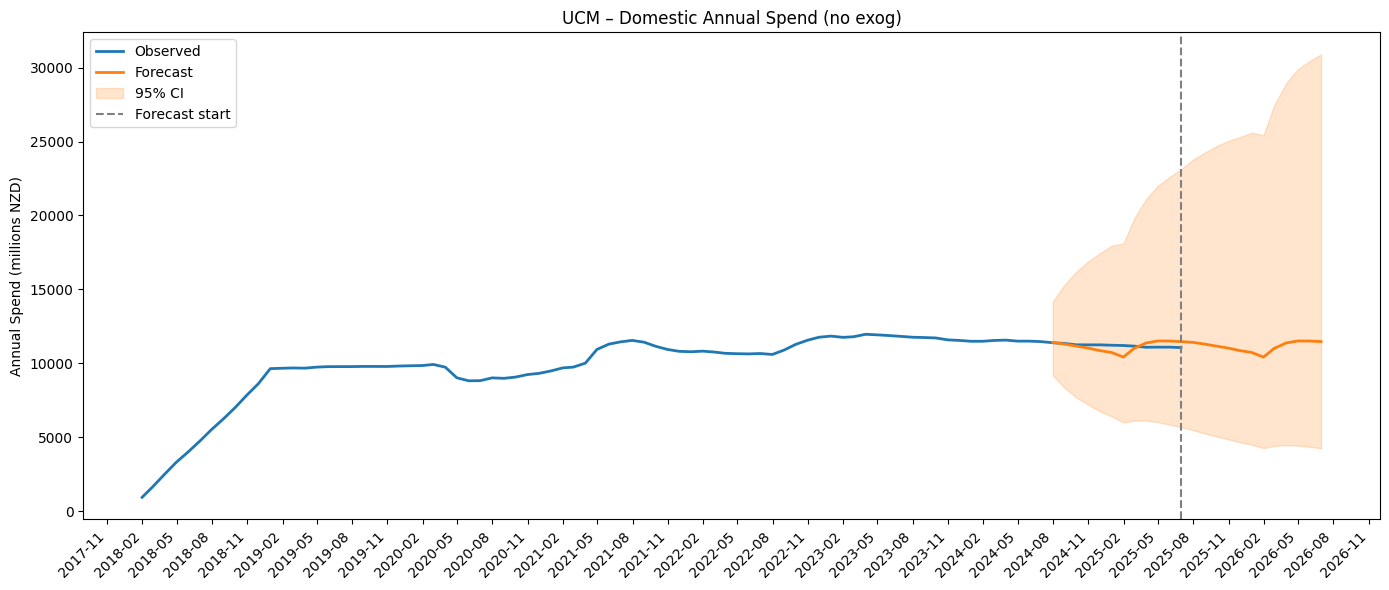


Forecast results written to: ../output/Model_01_UCM_TECT_AnnualSpend_domestic.csv (Domestic)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.tseries.offsets import MonthEnd
from statsmodels.tsa.statespace.structural import UnobservedComponents

TECT_REGION_PATH = "../datasets/TECT/Region-series.csv"

# ------------ helpers ------------
def _full_month_range(idx):
    start = pd.to_datetime(idx.min()) + MonthEnd(0)
    end = pd.to_datetime(idx.max()) + MonthEnd(0)
    return pd.date_range(start=start, end=end, freq="ME")

def _configure_ax(ax):
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

def _plot_ucm(y, y_pred_all, ci_all, test_end, title):
    """Two-line plot:
    - Observed: full history
    - Forecast: test overlap + future
    - Vertical line at the end of the test window (forecast start for unseen future)
    """
    plt.figure(figsize=(14, 6))
    plt.plot(y.index, y.values, label="Observed", color="tab:blue", linewidth=2)
    plt.plot(y_pred_all.index, y_pred_all.values, label="Forecast", color="tab:orange", linewidth=2)
    plt.fill_between(
        ci_all.index, ci_all.iloc[:, 0].values, ci_all.iloc[:, 1].values,
        color="tab:orange", alpha=0.20, label="95% CI",
    )
    plt.axvline(test_end, color="gray", linestyle="--", label="Forecast start")
    plt.title(title)
    plt.ylabel("Annual Spend (millions NZD)")
    plt.legend()
    _configure_ax(plt.gca())
    plt.tight_layout()
    plt.show()

# Accuracy metrics
def _accuracy_metrics(actual, forecast):
    err = forecast - actual
    mae = np.mean(np.abs(err))
    rmse = np.sqrt(np.mean(err**2))
    mape = np.mean(np.abs(err / actual)) * 100
    smape = np.mean(2.0 * np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast))) * 100
    return {"RMSE": rmse, "MAE": mae, "MAPE%": mape, "sMAPE%": smape}

# ------------ load & prepare TECT only ------------
tect = pd.read_csv(TECT_REGION_PATH, parse_dates=["Date"])
tect["Date"] = tect["Date"] + MonthEnd(0)
tect = tect.sort_values("Date").rename(
    columns={
        "Visitor Type": "VisitorType",
        "Annual Spend": "AnnualSpend",
        "Monthly Spend": "MonthlySpend",
    }
)

all_months = _full_month_range(tect["Date"])

intl_tect = (
    tect[tect["VisitorType"] == "International"]
    .groupby("Date")[["AnnualSpend"]]
    .sum()
    .reindex(all_months)
    .fillna(0.0)
)
dom_tect = (
    tect[tect["VisitorType"] == "New Zealand"]
    .groupby("Date")[["AnnualSpend"]]
    .sum()
    .reindex(all_months)
    .fillna(0.0)
)

intl_y = intl_tect["AnnualSpend"].astype(float)
dom_y  = dom_tect["AnnualSpend"].astype(float)

# ------------ UCM fit + forecast function (no exog) ------------
def ucm_forecast_no_exog(
    y_fit: pd.Series,
    k_test: int = 12,
    h_future: int = 12,
    title: str = "UCM Forecast (overlap)",
    model_label: str = "Model",
):
    if len(y_fit) <= k_test + 24:
        print(f"[{title}] Skipping (too few obs).")
        return None, None, None, None

    # Split
    y_train, y_test = y_fit.iloc[:-k_test], y_fit.iloc[-k_test:]

    # Model: local level + seasonal(12) on log1p(y)
    mod = UnobservedComponents(np.log1p(y_train), level="local level", seasonal=12)
    try:
        res = mod.fit(disp=False)
    except Exception:
        res = mod.fit(method="powell", disp=False)

    # Forecast steps: test horizon + future horizon
    steps_all = k_test + max(h_future, 0)
    fc_all = res.get_forecast(steps=steps_all)

    # Back-transform to level space
    y_pred_all = np.expm1(fc_all.predicted_mean)
    ci_all = np.expm1(fc_all.conf_int())

    # Ensure a proper monthly index on forecasts
    start_next = y_train.index[-1] + MonthEnd(1)
    fc_index = pd.date_range(start=start_next, periods=steps_all, freq="ME")
    y_pred_all.index = fc_index
    ci_all.index = fc_index

    # Metrics on the test window
    y_pred_test = y_pred_all.iloc[:k_test]
    mets = _accuracy_metrics(y_test, y_pred_test)
    print(f"[UCM] Hold-out accuracy ({y_test.index[0]} → {y_test.index[-1]}):")
    for k, v in mets.items():
        print(f"   {k:7}: {v:,.3f}" if np.isfinite(v) else f"   {k:7}: nan")

    # Full-history fit for AIC reporting
    mod_full = UnobservedComponents(np.log1p(y_fit), level="local level", seasonal=12)
    try:
        res_full = mod_full.fit(disp=False)
    except Exception:
        res_full = mod_full.fit(method="powell", disp=False)
    print(f"[UCM] {title} | AIC (full-history): {res_full.aic:.2f}")

    # Plot
    _plot_ucm(y_fit, y_pred_all, ci_all, test_end=y_test.index[-1], title=title)

    # Save forecast results to CSV (append or create)
    out_csv = "../output/Model_01_UCM_TECT_AnnualSpend"
    out_csv = str(f"{out_csv}_{model_label.lower()}.csv")
    df_out = pd.DataFrame(
        {
            "Observed": y_fit.reindex(y_pred_all.index),
            "Forecast": y_pred_all,
            "Lower_CI": ci_all.iloc[:, 0],
            "Upper_CI": ci_all.iloc[:, 1],
            "Model": model_label,
        }
    )
    df_out.index.name = "Date"
    df_out.to_csv(out_csv)
    print(f"\nForecast results written to: {out_csv} ({model_label})")

    return res_full, y_pred_all, ci_all, mets

# ------------ Run the two UCM models (no ADP/exog) ------------
ucm_intl_res, ucm_intl_fc_mean, ucm_intl_fc_ci, intl_metrics = ucm_forecast_no_exog(
    intl_y,
    k_test=12,
    h_future=12,
    title="UCM – International Annual Spend (no exog)",
    model_label="International",
)

ucm_dom_res, ucm_dom_fc_mean, ucm_dom_fc_ci, dom_metrics = ucm_forecast_no_exog(
    dom_y,
    k_test=12,
    h_future=12,
    title="UCM – Domestic Annual Spend (no exog)",
    model_label="Domestic",
)
